# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model; compute_MAP=true);

In [8]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479853151597, 0.060888704439630306] ✅


eps: 0.5 --> VarE: 0.4953140941735926
eps: 0.8282325763448337 --> VarE: 1.2975470777650566
eps: 0.6240674582550091 --> VarE: 0.886793420711372
eps: 0.6913816713153413 --> VarE: 0.768022042182822
eps: 0.8441728703063509 --> VarE: 1.5535133001486732
eps: 0.5365602915665885 --> VarE: 0.6265775231746527
eps: 0.7176633968863969 --> VarE: 0.8375973764678073
eps: 0.809414765789467 --> VarE: 1.139813402187691
eps: 0.7334699551868114 --> VarE: 1.0292460185051922


[ Info: Found eps: 0.7334699551868114 ✅


samples: 100--> ESS: 0.2460838173912336


[ Info: Found L: 1.1922278562847752 ✅


In [9]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

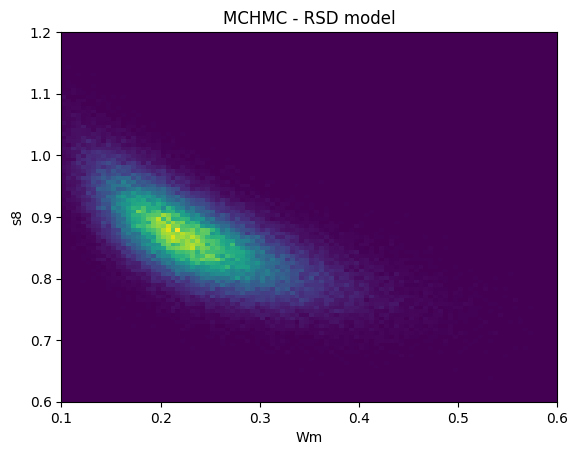

In [10]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [11]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.5 --> VarE: 0.516539160462091


[ Info: VarE condition met during eps tuning at step: 1
[ Info: Found eps: 0.5 ✅


Initial Virial loss: 2655.8560052382186
Initial sigma: [1.7024329836451206, 0.31663009869015385]
Virial loss: 14.743866632801373 --> Relative improvement: 0.7139057486601292
Sigma --> [1.5940753668122218, 0.2780293300889023]
Virial loss: 12.709740041966409 --> Relative improvement: 0.13796425601880757
Sigma --> [1.4935707301461922, 0.2499030144979288]
Virial loss: 4.567216776598778 --> Relative improvement: 0.6406522272274457
Sigma --> [1.4146665236697684, 0.227752617657114]
Virial loss: 10.086496510476302 --> Relative improvement: 1.2084558285380425
Sigma --> [1.3431650443948149, 0.21026989462311843]
Virial loss: 1.6644993192900661 --> Relative improvement: 0.8349774554959455
Sigma --> [1.280096343219395, 0.196663389836852]
Virial loss: 9.385333088683634 --> Relative improvement: 4.638532248055601
Sigma --> [1.2252527789824708, 0.1850743696566195]
Virial loss: 1.4666547711480897 --> Relative improvement: 0.8437290656293799
Sigma --> [1.173994489455776, 0.1755416226518309]
Virial loss:

[ Info: Virial loss condition met during burn-in at step: 32
[ Info: Found sigma: [0.764357040959842, 0.10692326674603475] ✅


eps: 0.5 --> VarE: 0.0023058915813183468
eps: 0.5244248859669532 --> VarE: 0.00994750008972359
eps: 0.5458557281935318 --> VarE: 0.01622917753842169
eps: 0.5646045243800071 --> VarE: 0.020152278237094267
eps: 0.581710703412744 --> VarE: 0.021747505609960985
eps: 0.598379845452732 --> VarE: 0.02561867700481124
eps: 0.613148445147277 --> VarE: 0.025947006130969494
eps: 0.6280752990522718 --> VarE: 0.057754220383981675
eps: 0.6232238984889547 --> VarE: 0.04337256193509288
eps: 0.6273679934747968 --> VarE: 0.09368089695920262
eps: 0.6005538921478047 --> VarE: 0.03416469609209607
eps: 0.6101395410702033 --> VarE: 0.0379895511762558
eps: 0.6175117740965972 --> VarE: 0.03088760873127782
eps: 0.6294274061339235 --> VarE: 0.07585559457305228
eps: 0.6133617745317372 --> VarE: 0.038348046054141
eps: 0.6205504373323083 --> VarE: 0.04600713100887879


[ Info: VarE condition met during eps tuning at step: 16
[ Info: Found eps: 0.6205504373323083 ✅


In [12]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

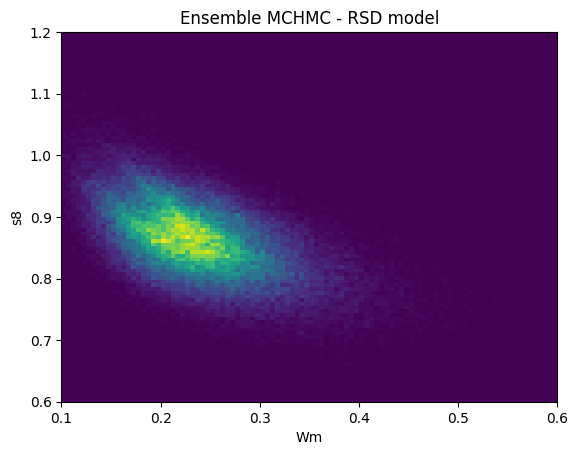

In [13]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852953616, 0.06088870443747055] ✅


eps: 0.5 --> VarE: 0.5762429034230809
eps: 2.076346618614184 --> VarE: 25.055894774390982
eps: 6.20289009853641e-10 --> VarE: 3.865651995357446e-21
eps: 3.789011137425285e-9 --> VarE: 1.4423708158451433e-19
eps: 2.118982310687817e-8 --> VarE: 4.5112257615613425e-18
eps: 1.0896018392978165e-7 --> VarE: 1.1930564017819597e-16
eps: 5.172798875506445e-7 --> VarE: 2.6915884393956934e-15
eps: 2.2761041127856254e-6 --> VarE: 5.241508969601153e-14
eps: 9.317006987208886e-6 --> VarE: 9.201475222643324e-13
eps: 3.560483810608881e-5 --> VarE: 2.016257977375223e-11
eps: 0.0001274517464451888 --> VarE: 1.2520440323907692e-9
eps: 0.000428717910934223 --> VarE: 1.1267483940720306e-7
eps: 0.0013592640711706876 --> VarE: 0.00010331268163694111
eps: 0.004073530231046214 --> VarE: 0.00035596532856638175
eps: 0.011570002131824358 --> VarE: 0.0012584852668583318
eps: 0.03121695534513542 --> VarE: 0.0075310398512413255
eps: 0.08000883626631126 --> VarE: 0.06712387586552004
eps: 0.19068718461278844 --> VarE:

[ Info: Found eps: 0.9260513212809793 ✅
[ Info: Found L: 0.7270931392265114 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.11 seconds
Compute duration  = 2.11 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2364    0.0636     0.0006    0.0020    925.5775    1.0000    ⋯
          σ8    0.8656    0.0590     0.0006    0.0018   1045.5690    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1312    0.1910    0.2301    0.2731    0.3786
          σ8    0.7576    0.8260    0.8630    0.9026    0.9889


In [15]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.73 seconds
Compute duration  = 0.73 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2371    0.0631     0.0006    0.0020   878.4538    1.0002     ⋯
          σ8    0.8638    0.0589     0.0006    0.0019   899.1869    0.9999     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1326    0.1914    0.2302    0.2765    0.3775
          σ8    0.7526    0.8232    0.8623    0.9032    0.9835


## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 7
[ Info: Found eps: 0.009335477501157657 ✅
┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:197
[ Info: Found sigma: [1.6328259946191415, 0.235443065129492] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.020543875719697603 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.46 seconds
Compute duration  = 3.46 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2860    0.1348     0.0004    0.0073   220.7480    1.0000     ⋯
          σ8    0.8328    0.1790     0.0006    0.0096   227.8723    1.0105     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0541    0.1923    0.2593    0.3770    0.5664
          σ8    0.4247    0.7522    0.8365    0.9091    1.1003


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.17 seconds
Compute duration  = 3.17 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2527    0.0740     0.0002    0.0039   228.5743    1.0051     ⋯
          σ8    0.8592    0.0618     0.0002    0.0033   224.4774    1.0160     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1525    0.2000    0.2388    0.2915    0.4280
          σ8    0.7498    0.8214    0.8593    0.8920    1.0106


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

eps: 0.5 --> VarE: 0.6965167477733917
eps: 0.5 --> VarE: 2.302937164684367
eps: 0.5 --> VarE: 0.6783607554526879


[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.4504347985295365, 0.06088870443747063] ✅
[ Info: Found sigma: [0.4504347985295365, 0.06088870443747063] ✅
[ Info: Found sigma: [0.4504347985295365, 0.06088870443747063] ✅
[ Info: Found sigma: [0.4504347985295365, 0.06088870443747063] ✅


eps: 0.5 --> VarE: 0.9252330903914279
eps: 1.841050019573843 --> VarE: 20.60974465395169
eps: 1.8747813963037052 --> VarE: 20.635695292324826
eps: 0.3693227539679783 --> VarE: 1.8323872389860314
eps: 1.4646550134651826 --> VarE: 4.594695734249147
eps: 3.776811436490186e-8 --> VarE: 4.4333277217137044e-18
eps: 3.752232889015937e-8 --> VarE: 6.170826875608277e-17
eps: 0.43316084430587265 --> VarE: 2.1107289939447145
eps: 0.1241169266290423 --> VarE: 0.17725191847470367
eps: 0.3918649977401867 --> VarE: 1.897304930469329
eps: 2.292036773317879e-7 --> VarE: 2.2977477703379893e-15
eps: 2.307050482837517e-7 --> VarE: 1.6553781349322003e-16
eps: 0.6458160725343685 --> VarE: 1.042173109261273
eps: 0.42807904043192524 --> VarE: 2.0101757563466647
samples: 100--> ESS: 0.07602818545292837
eps: 1.2902044849407318e-6 --> VarE: 5.20364697834378e-15
eps: 1.2818081557307984e-6 --> VarE: 7.37564849665409e-14
samples: 203--> ESS: 0.06820633186007416
eps: 1.4728049497624582 --> VarE: 5.7439136072471975
e

[ Info: Found eps: 0.42807904043192524 ✅
[ Info: Found L: 2.5104944292276725 ✅


eps: 0.06869433827804335 --> VarE: 0.07146546301655161
eps: 3.129113326295002e-5 --> VarE: 2.1051187915600064e-9
eps: 3.149610204488989e-5 --> VarE: 6.2015097533534445e-12
eps: 0.3084658039960629 --> VarE: 0.5677448362472819
eps: 0.00013768537829625076 --> VarE: 1.3847751312008078e-6
eps: 0.0001385872699211445 --> VarE: 9.406244345311935e-10
eps: 0.8912738335955345 --> VarE: 1.8878581249751536
eps: 0.0005636009234382254 --> VarE: 2.1957992141229876e-5
eps: 0.0005672932771767672 --> VarE: 4.701526177881928e-7
eps: 0.9645645508171617 --> VarE: 2.804073999235429
eps: 0.002153762930796012 --> VarE: 0.00010151679808809632
eps: 0.0021679042373498885 --> VarE: 3.926638977852384e-5
eps: 0.5626680452863755 --> VarE: 0.8786434203377158
eps: 0.007709151163346628 --> VarE: 0.0019103401265582168
eps: 0.007760076384621743 --> VarE: 0.00030333164415649073
eps: 1.1502083281195294 --> VarE: 4.193563834222343
eps: 0.02590175496139391 --> VarE: 0.011363076755115355
eps: 0.026098282746447852 --> VarE: 0.0

[ Info: Found eps: 0.9024081767802767 ✅
[ Info: Found L: 1.7504381000862341 ✅


eps: 0.7873568503570765 --> VarE: 1.1492620483800742
eps: 0.9381062065763941 --> VarE: 2.3312897820755385
eps: 1.0173117864391426 --> VarE: 2.9468131089335134
eps: 0.849018184149498 --> VarE: 1.6730630912811537
eps: 0.7756120241624915 --> VarE: 1.002854027256458
eps: 0.9323885220905564 --> VarE: 2.218734468636814
eps: 1.0178078289559072 --> VarE: 3.074506224078558
eps: 0.8784311216698993 --> VarE: 1.9883605750819597
samples: 100--> ESS: 0.5135677275575914
eps: 0.7703547573413461 --> VarE: 1.2048326449887383
eps: 0.9372377525865109 --> VarE: 1.9699821349801925


[ Info: Found eps: 0.8784311216698993 ✅
[ Info: Found L: 0.6841793785193734 ✅
[ Info: Found eps: 0.9372377525865109 ✅
[ Info: Found L: 1.130089223370722 ✅


samples: 100--> ESS: 0.33173938241478235


chain 3:   4%|█▉                                        |  ETA: 0:00:02
chain 1:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   4%|█▉                                        |  ETA: 0:00:02
chain 4:   5%|██▏                                       |  ETA: 0:00:02
chain 1:  10%|████▎                                     |  ETA: 0:00:02
chain 3:  11%|████▋                                     |  ETA: 0:00:02

chain 2:  10%|████▎                                     |  ETA: 0:00:02
chain 3:  17%|███████▏                                  |  ETA: 0:00:02
chain 1:  16%|██████▌                                   |  ETA: 0:00:02
chain 2:  16%|██████▊                                   |  ETA: 0:00:02
chain 4:  17%|███████▏                                  |  ETA: 0:00:02
chain 3:  22%|█████████▌                                |  ETA: 0:00:01
chain 1:  21%|████████▉                                 |  ETA: 0:00:02
chain 4:  23%|█████████▋                                |  ETA:

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run
chain 3:   4%|█▉                                        |  ETA: 0:00:02
chain 2:   4%|█▉                                        |  ETA: 0:00:02
chain 4:   4%|█▉                                        |  ETA: 0:00:02
chain 1:   5%|██▏                                       |  ETA: 0:00:02

chain 4:  10%|████▎                                     |  ETA: 0:00:02
chain 2:  10%|████▍                                     |  ETA: 0:00:02
chain 1:  10%|████▍                                     |  ETA: 0:00:02
chain 3:  16%|██████▉                                   |  ETA: 0:00:02
chain 2:  16%|██████▉                                   |  ETA: 0:00:02
chain 4:  16%|██████▊                                   |  ETA: 0:00:02
chain 1:  16%|██████▊                                   |  ETA: 0:00:02
chain 2:  22%|█████████▌                                |  ETA: 0:00:02
chain 3:  22%|█████████▌                                |  ETA: 0:00:02
chain 4:  22%|█████████▎    

4-element Vector{Chains}:
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})
 MCMC chain (30000×4×1 Array{Float64, 3})

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.41 seconds
Compute duration  = 9.41 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2367    0.0656     0.0007    0.0015   1680.4345    1.0014    ⋯
          σ8    0.8661    0.0611     0.0006    0.0011   2579.4440    1.0004    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.505744  0.755005  11.0963   1.0  1.0  …  1.0  0.0  0.0565015  0.0565015
 0.505744  0.755005  11.0963   1.0  1.0     1.0  0.0  0.0565015  0.0565015
 0.479442  0.704872  10.7634   9.0  1.0     3.0  0.0  0.0565015  0.0565015
 0.477996  0.741131  11.8464   1.0  1.0     1.0  0.0  0.0565015  0.0565015
 0.277406  0.816538  15.9222  31.0  1.0     4.0  0.0  0.0565015  0.0565015
 0.277406  0.816538  15.9222   1.0  1.0  …  1.0  0.0  0.0565015  0.0565015
 0.277554  0.79716   15.5702   1.0  1.0     1.0  0.0  0.0565015  0.0565015
 0.279103  0.768495  14.5444   1.0  1.0     1.0  0.0  0.0565015  0.0565015
 0.241389  0.8899    15.7837  11.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

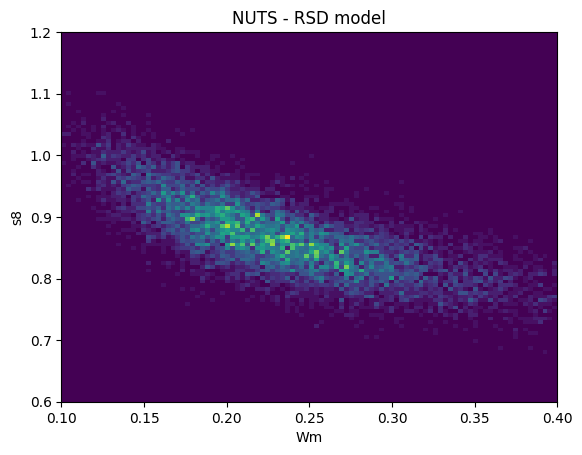

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");